In [1]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 15.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [3]:
from getpass import getpass
import os

os.environ['HF_TOKEN'] = getpass('Huggingface Access Token: ')

Huggingface Access Token: ··········


In [4]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
# Load the FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=3)  # Adjust the number of labels if needed

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [6]:
# Load dataset
df = pd.read_csv("all-data.csv")
df.head(4)

,result,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...


In [7]:
# Split dataset
df_train, df_test = train_test_split(df, stratify=df['result'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['result'], test_size=0.1, random_state=42)

In [8]:
# Prepare datasets for fine-tuning
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

In [10]:
# Tokenize datasets
def tokenize_data(example):
    return tokenizer(example['content'], truncation=True, padding='max_length', max_length=128)

In [11]:
dataset_train = dataset_train.map(tokenize_data, batched=True)
dataset_val = dataset_val.map(tokenize_data, batched=True)
dataset_test = dataset_test.map(tokenize_data, batched=True)

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [12]:
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [13]:
# Define a mapping for your labels
label_map = {'positive': 0, 'neutral': 2, 'negative': 1}

# Ensure the labels are in the correct format
def format_labels(example):
    example['labels'] = label_map[example['result']]
    return example

dataset_train = dataset_train.map(format_labels)
dataset_val = dataset_val.map(format_labels)
dataset_test = dataset_test.map(format_labels)

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [14]:
# Set the format of the datasets to PyTorch tensors
dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dataset_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [15]:
# Define a function to compute metrics based on predictions and labels
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

In [28]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='temp_output/',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
# Initialize the Trainer with the model, training arguments, and datasets
trainer = Trainer(
    model=model,  # the Hugging Face Transformers model to be trained
    args=training_args,
    train_dataset=dataset_train,  # your training dataset
    eval_dataset=dataset_val,    # your validation dataset
    compute_metrics=compute_metrics,
)

In [30]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1812 MiB |  14938 MiB | 174572 MiB | 172759 MiB |\n|       from large pool |   1810 MiB |  14932 MiB | 173893 MiB | 172082 MiB |\n|       from small pool |      2 MiB |     15 MiB |    679 MiB |    676 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   1812 MiB |  14938 MiB | 174572 MiB | 172759 MiB |\n|       from large pool |   1810 MiB |  14932 MiB |

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.236492,0.922197
2,No log,0.235939,0.919908
3,No log,0.246495,0.922197
4,No log,0.245337,0.924485
5,No log,0.252270,0.926773


TrainOutput(global_step=155, training_loss=0.14968849920457408, metrics={'train_runtime': 455.4957, 'train_samples_per_second': 43.074, 'train_steps_per_second': 0.34, 'total_flos': 1290571313955840.0, 'train_loss': 0.14968849920457408, 'epoch': 5.0})

In [32]:

model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.3323202431201935,
 'test_accuracy': 0.8804123711340206,
 'test_runtime': 3.369,
 'test_samples_per_second': 143.961,
 'test_steps_per_second': 1.187}

In [37]:
texts = list(df.content.values)

In [33]:
model_path='finbert-sentiment/'
# Save the model
trainer.model.save_pretrained(model_path)

# Save the tokenizer associated with the model
# Save the tokenizer
tokenizer.save_pretrained(model_path)



('finbert-sentiment/tokenizer_config.json',
 'finbert-sentiment/special_tokens_map.json',
 'finbert-sentiment/vocab.txt',
 'finbert-sentiment/added_tokens.json',
 'finbert-sentiment/tokenizer.json')

In [36]:
from transformers import pipeline
senti=pipeline('sentiment-analysis', model=model_path, tokenizer=model_path)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [38]:
results=senti(texts)

In [39]:
results

[{'label': 'neutral', 'score': 0.9921261072158813},
 {'label': 'neutral', 'score': 0.9574199318885803},
 {'label': 'negative', 'score': 0.9884246587753296},
 {'label': 'positive', 'score': 0.9856417775154114},
 {'label': 'positive', 'score': 0.9815966486930847},
 {'label': 'positive', 'score': 0.9822283387184143},
 {'label': 'positive', 'score': 0.98436039686203},
 {'label': 'positive', 'score': 0.9875465035438538},
 {'label': 'positive', 'score': 0.9866361021995544},
 {'label': 'positive', 'score': 0.9873142838478088},
 {'label': 'positive', 'score': 0.9840509295463562},
 {'label': 'positive', 'score': 0.9863119721412659},
 {'label': 'positive', 'score': 0.9703145623207092},
 {'label': 'positive', 'score': 0.9868319034576416},
 {'label': 'positive', 'score': 0.9869837760925293},
 {'label': 'positive', 'score': 0.9877671003341675},
 {'label': 'positive', 'score': 0.98692387342453},
 {'label': 'positive', 'score': 0.9835702180862427},
 {'label': 'positive', 'score': 0.9859189987182617},

In [40]:
df

,result,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


<Axes: >

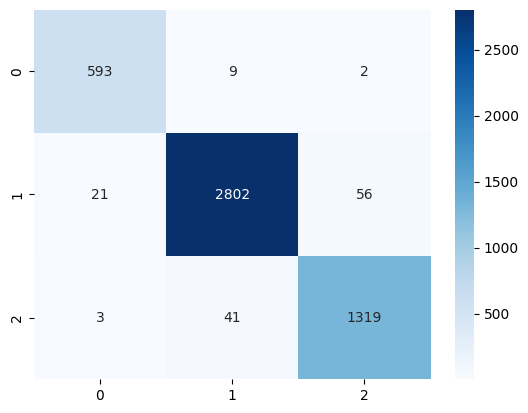

In [41]:

df['sentiment'] = [r['label'] for r in results]
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = df['result']
y_pred = df['sentiment']

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [43]:
df

,result,content,sentiment
0,neutral,"According to Gran , the company has no plans t...",neutral
1,neutral,Technopolis plans to develop in stages an area...,neutral
2,negative,The international electronic industry company ...,negative
3,positive,With the new production plant the company woul...,positive
4,positive,According to the company 's updated strategy f...,positive
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,negative,Net sales of the Paper segment decreased to EU...,negative


In [42]:

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9727610400330169
